In [1]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("MODEL")                  # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")

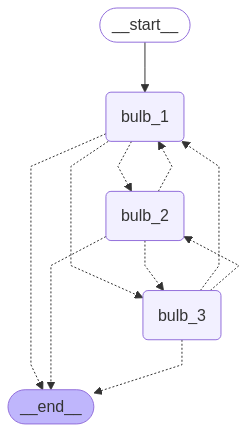

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'Turn ON')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'Turn ON')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Turn ON', additional_kwargs={}, response_metadata={}, id='c069a867-d862-4908-84c4-d65584585091')]}
[1:tasks] Starting 1 task for step 1:
- bulb_1 -> {'messages': [HumanMessage(content='Turn ON', additional_kwargs={}, response_metadata={}, id='c069a867-d862-4908-84c4-d65584585091')]}
((), {'bulb_1': {'messages': [HumanMessage(content='I am ON', additional_kwargs={}, response_metadata={}, name='bulb_1')]}})
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [HumanMessage(content='I am ON', additional_kwargs={}, response_metadata={}, name='bulb_1')]
[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='Turn ON', additional_kwargs={}, r

In [4]:
# Network
# Each agent can communicate with every other agent (many-to-many connections) 
# and can decide which agent to call next.

from typing import Literal
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

llm = ChatOpenAI(model="gpt-4.1")

class Router(TypedDict):
    """Next bulb to toggle. If all bulbs are already ON, route to __end__."""
    next_agent: Literal["bulb_1", "bulb_2", "bulb_3", END]

system_prompt = (
    "You are a bulb part of a group of bulbs (bulb_1, bulb_2, bulb_3) that can be turned ON or OFF with a single user command."
    "Given the following user request, respond with the bulb name which is still OFF to act next. Each bulb should be turned ON "
    " and respond with their status. If you already see all bulbs are already ON then"
    f"respond with {END}"
)

def bulb_1(state: MessagesState) -> Command[Literal["bulb_2", "bulb_3", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)
    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response["next_agent"],
        update={
            "messages": [
                HumanMessage(content="I am ON", name="bulb_1")
            ]
        },
    )

def bulb_2(state: MessagesState) -> Command[Literal["bulb_1", "bulb_3", END]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)
    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response["next_agent"],
        update={
            "messages": [
                HumanMessage(content="I am ON", name="bulb_2")
            ]
        },
    )

def bulb_3(state: MessagesState) -> Command[Literal["bulb_1", "bulb_2", END]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)
    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response["next_agent"],
        update={
            "messages": [
                HumanMessage(content="I am ON", name="bulb_3")
            ]
        },
    )

builder = StateGraph(MessagesState)
builder.add_node(bulb_1)
builder.add_node(bulb_2)
builder.add_node(bulb_3)

builder.add_edge(START, "bulb_1")
network = builder.compile()

from IPython.display import display, Image

display(Image(network.get_graph().draw_mermaid_png()))

for s in network.stream(
    {"messages": [("user", "Turn ON")]}, subgraphs=True,debug=True):
    print(s)
    print("============================")

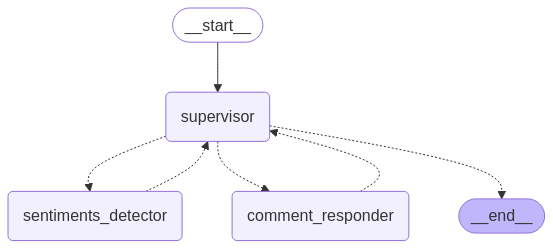

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'Not sure whether the new design is to my liking or not!')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'Not sure whether the new design is to my liking or not!')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Not sure whether the new design is to my liking or not!', additional_kwargs={}, response_metadata={}, id='c3e598d8-d8ed-478a-9eec-1fc4b7a89126')]}
[1:tasks] Starting 1 task for step 1:
- supervisor -> {'messages': [HumanMessage(content='Not sure whether the new design is to my liking or not!', additional_kwargs={}, response_metadata={}, id='c3e598d8-d8ed-478a-9eec-1fc4b7a89126')]}
((), {'supervisor': {'next': 'sentiments_detector'}})
[1:writes] Finished step 1 with writes to 1 channel:
- next -> 'sentiments_detector'
[1:checkpoint] State at the end of step 1:
{'me

In [10]:
# Supervisor
# A supervisor node (LLM) that decides which agent nodes should be called next.

from typing import Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

llm = ChatOpenAI(model="gpt-4o")

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to __end__."""
    next: Literal["sentiments_detector", "comment_responder", END]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: sentiments_detector, comment_responder." 
    " Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status."
    " You will NOT perform the requested taks, but will always use the workers. When finished,"
    " respond with __end__."
)

class State(MessagesState):
    next: str

def supervisor_node(state: State) -> Command[Literal["sentiments_detector", "comment_responder", END]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    return Command(goto=goto, update={"next": goto})

sentiments_detector_agent = create_react_agent(
    llm, 
    tools=[], 
    name="sentiments_detector_agent",
    prompt="You are a sentiment detector. You detect customer sentiments from the provided comment, You can response with Positive, Negative or Neutral."
)

def sentiments_detector_node(state: State) -> Command[Literal["supervisor"]]:
    result = sentiments_detector_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="sentiments_detector")
            ]
        },
        goto="supervisor",
    )

comment_responder_agent = create_react_agent(
    llm, 
    tools=[], 
    name="comment_responder_agent",
    prompt="You are a comment responder. You write a response to the provided comment."
)

def comment_responder_node(state: State) -> Command[Literal["supervisor"]]:
    result = comment_responder_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="comment_responder")
            ]
        },
        goto="supervisor",
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("sentiments_detector", sentiments_detector_node)
builder.add_node("comment_responder", comment_responder_node)

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

for s in graph.stream(
    {"messages": [("user", "Not sure whether the new design is to my liking or not!")]}, subgraphs=True,debug=True):
    print(s)
    print("============================")

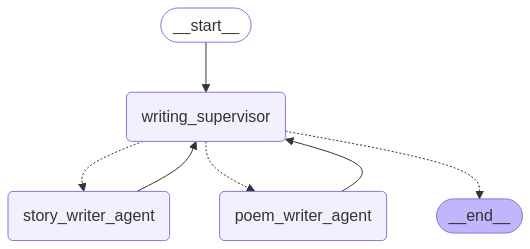

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': 'Topic: Blue sky', 'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': 'Topic: Blue sky', 'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Topic: Blue sky', additional_kwargs={}, response_metadata={}, id='12ceb89c-3e3c-45b9-a1d0-8402663e6eea')]}
[1:tasks] Starting 1 task for step 1:
- writing_supervisor -> {'is_last_step': False,
 'messages': [HumanMessage(content='Topic: Blue sky', additional_kwargs={}, response_metadata={}, id='12ceb89c-3e3c-45b9-a1d0-8402663e6eea')],
 'remaining_steps': 24}
(('writing_supervisor:0389d235-ebe1-33b7-a7ac-c49ef3d4fac8',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IkK11A3IgrK3sOvqcQrGmYWn', 'function': {'arguments': '{}', 'name': 'transfer_to_story_writer_agent'}, 'type': '

In [49]:
# Hierarchical
# A supervisor of supervisor.

from langchain_openai import ChatOpenAI
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

story_writer_agent = create_react_agent(
    llm, 
    tools=[], 
    name="story_writer_agent",
    prompt="You are a story writer. Write a creative short story of 100 words on the given topic."
)

poem_writer_agent = create_react_agent(
    llm, 
    tools=[], 
    name="poem_writer_agent",
    prompt="You are a poem writer. Write a creative poem of 50 words on the given topic."
)

# Create supervisor workflow
writing_supervisor = create_supervisor(
    agents=[story_writer_agent, poem_writer_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a story writing expert and a poem writing expert. "
        "For writing stories, use story_writer_agent. "
        "For writing poems, use poem_writer_agent."
    ),
    supervisor_name="writing_supervisor"
)

# Compile and run
writer_team = writing_supervisor.compile(name="writer_team")

from IPython.display import display, Image

display(Image(writer_team.get_graph().draw_mermaid_png()))

for s in writer_team.stream({
    "messages": [
        {
            "role": "user",
            "content": "Topic: Blue sky"
        }]}, subgraphs=True,debug=True):
    print(s)
    print("============================")

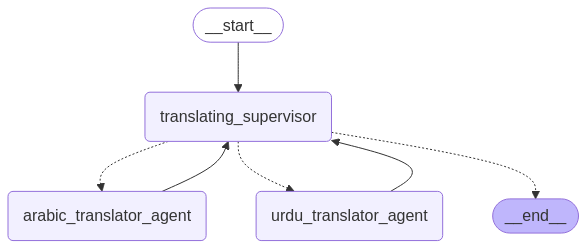

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'Life is beautiful')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'Life is beautiful')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Life is beautiful', additional_kwargs={}, response_metadata={}, id='c82db91b-ee37-4e77-9004-15014bd93080')]}
[1:tasks] Starting 1 task for step 1:
- translating_supervisor -> {'is_last_step': False,
 'messages': [HumanMessage(content='Life is beautiful', additional_kwargs={}, response_metadata={}, id='c82db91b-ee37-4e77-9004-15014bd93080')],
 'remaining_steps': 24}
(('translating_supervisor:dd9e8874-6f37-29c7-85a3-bfea7bdbbe72',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pEr5vCTZvNKqr67KeXrTy3uG', 'function': {'arguments': '{}', 'name': 'transfer_to_urdu_translator_agent'}, 'type': 'function'}, {'id': 

In [50]:
# Hierarchical
# A supervisor of supervisor.

urdu_translator_agent = create_react_agent(
    llm, 
    tools=[], 
    name="urdu_translator_agent",
    prompt="You translate given text into Urdu."
)

arabic_translator_Agent = create_react_agent(
    llm, 
    tools=[], 
    name="arabic_translator_agent",
    prompt="You translate given text into Arabic."
)

# Create supervisor workflow
translating_supervisor = create_supervisor(
    agents=[urdu_translator_agent, arabic_translator_Agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a Urdu translator expert and a Arabic translator expert. "
        "For translating into Urdu, use urdu_translator_agent. "
        "For translating into Arabic, use arabic_translator_Agent."
    ),
    supervisor_name="translating_supervisor"
)

# Compile and run
translator_team = translating_supervisor.compile(name="translator_team")

from IPython.display import display, Image

display(Image(translator_team.get_graph().draw_mermaid_png()))

for s in translator_team.stream(
    {"messages": [("user", "Life is beautiful")]}, subgraphs=True,debug=True):
    print(s)
    print("============================")

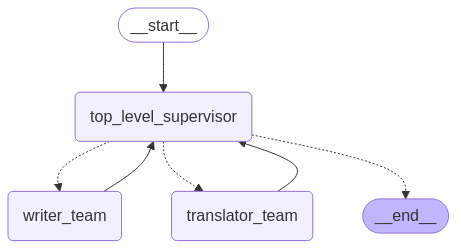

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'Topic: Life is beautiful')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'Topic: Life is beautiful')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Topic: Life is beautiful', additional_kwargs={}, response_metadata={}, id='f70b17cd-869c-4630-aa60-60abf5072504')]}
[1:tasks] Starting 1 task for step 1:
- top_level_supervisor -> {'is_last_step': False,
 'messages': [HumanMessage(content='Topic: Life is beautiful', additional_kwargs={}, response_metadata={}, id='f70b17cd-869c-4630-aa60-60abf5072504')],
 'remaining_steps': 24}
(('top_level_supervisor:78c3a85f-27c2-aa15-9d0d-c89f533a4ed7',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SB6gw9lCcvShdg8ieoazGR82', 'function': {'arguments': '{}', 'name': 'transfer_to_writer_team'}, 'type': 'funct

In [51]:

# Create supervisor workflow
top_level_supervisor = create_supervisor(
    agents=[writer_team, translator_team],
    model=llm,
    prompt=(
        "You are a team supervisor managing a team of writing and a language translating experts. "
        "Your task is to generate a short 100 words story and a 50 words poem for a given topic and then translate the generated story and poem into Arabic and Urdu language. "
        "For writing tasks, use writer_team and for translation tasks use translator_team."
        "Here is the input: "
    ),
    supervisor_name="top_level_supervisor"
)

# Compile and run
entire_team = top_level_supervisor.compile()

from IPython.display import display, Image

display(Image(entire_team.get_graph().draw_mermaid_png()))

for s in entire_team.stream(
    {"messages": [("user", "Topic: Life is beautiful")]}, subgraphs=True,debug=True):
    print(s)
    print("============================")